<a href="https://colab.research.google.com/github/jonjimenez99/Portafolio/blob/main/Sistema_recomendador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🧠 Reto: Recomendador implícito de Top-N productos
Contexto:
Trabajas en una plataforma de e-commerce.
Solo tienes registros de qué productos han sido vistos o clickeados por los usuarios. No hay ratings ni calificaciones, solo interacciones binarias (interactuó / no interactuó).

🎯 Objetivo
Construir un sistema que recomiende Top-5 productos para cada usuario basado en las interacciones históricas.

El sistema no debe recomendar productos que el usuario ya ha visto.

Evaluar la calidad de las recomendaciones usando Precision@5.



In [5]:
# Data generated:

import pandas as pd
import numpy as np

np.random.seed(42)

n_users = 200
n_items = 100

interactions = {
    "user_id": np.random.randint(0, n_users, size=2000),
    "item_id": np.random.randint(0, n_items, size=2000),
    "interaction": 1  # 1 = interacción positiva
}

df = pd.DataFrame(interactions)
df.head()


,user_id,item_id,interaction
0,102,21,1
1,179,65,1
2,92,37,1
3,14,89,1
4,106,45,1


In [13]:
# Exploratory Data Analysis [EDA]:

print(f"The amount of diferent users are {df['user_id'].nunique()}")
print(f"The amount of diferent ítems are {df['item_id'].nunique()}")
print(f"The amount of positive interactions are {df['interaction'].shape[0]:,.0f}")

The amount of diferent users are 200
The amount of diferent ítems are 100
The amount of positive interactions are 2,000


In [24]:
# Distribution of registers by each ítem:

group_item_id = df.groupby('item_id')['interaction'].count().reset_index()
group_item_id.sort_values(by='interaction', ascending=False, inplace=True)
group_item_id.head()

,item_id,interaction
20,20,39
7,7,31
18,18,29
59,59,29
46,46,28


<Axes: >

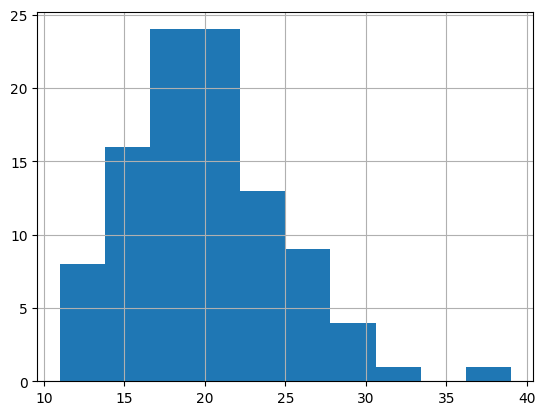

In [27]:
# Distribution of interactions for each ítem:
group_item_id = df.groupby('item_id')['interaction'].count().reset_index()
group_item_id.sort_values(by='interaction', ascending=False, inplace=True)
group_item_id.head()
group_item_id['interaction'].hist(bins=10)

<Axes: >

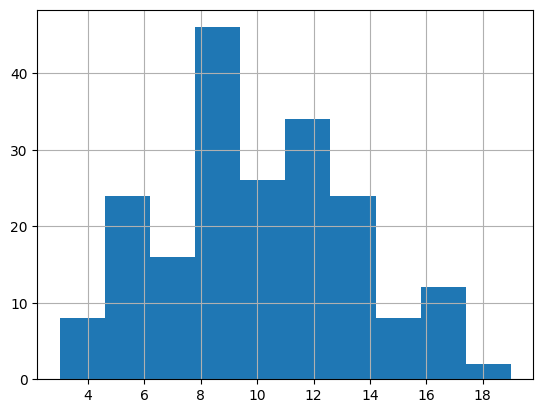

In [31]:
# Distribution of interactions for each user:

group_user_id = df.groupby('user_id')['interaction'].count().reset_index()
group_user_id.sort_values(by='interaction', ascending=False, inplace=True)
group_user_id.head()
group_user_id['interaction'].hist(bins=10)

In [86]:
# Create a utility matrix between user vs. item_id:

utility_matrix = df.pivot_table(index='user_id', columns='item_id', values='interaction', fill_value=0)
utility_matrix.head()

item_id,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# Transpose the user-item matrix because for this algorithm, it's necesary that rows are ítems to identify the relation:
X = utility_matrix.T

print(X.shape)
X.head()

(100, 200)


user_id,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
item_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# Al ser una matriz dispersa, se pueden utilizar técnicas de reducción de dimensiones como SVD. Para eso, se utilizará scikit-learn:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=100, random_state=42)
SVD.fit(X)

TruncatedSVD(n_components=100, random_state=42)

Se utilizó TruncatedSVD, porque es recomendado para matrices dispersas. Una matriz se considera como dispersa cuando está compuesta principalmente por ceros.

TruncatedSVD ayuda a que solo se calculen los n_components más importantes, disminuyendo significativamente el consumo computacional.

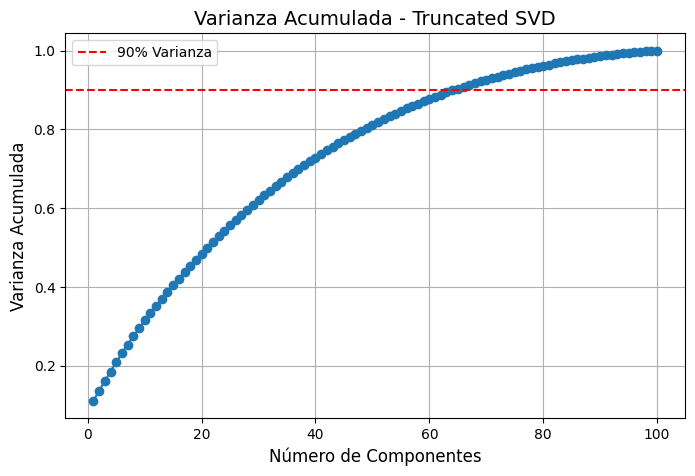

In [82]:
import matplotlib.pyplot as plt

# Cálculo de la varianza explicada
singular_values_squared = SVD.singular_values_**2 # El valor singular no es directamente la varianza. Se puede elevar al cuadrado el valor singular de cada componente, para saber la varianza de ese componente.
explained_variance_ratio = singular_values_squared / singular_values_squared.sum()

# Cálculo de la varianza acumulada
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Varianza Acumulada - Truncated SVD', fontsize=14)
plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Acumulada', fontsize=12)
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Varianza')
plt.legend()
plt.show()

In [83]:
num_sv = 7

# Calculamos varianza explicada para el TOP n componentes:
explained_variance = (SVD.singular_values_[:num_sv]**2).sum() / (SVD.singular_values_**2).sum()

print(f'Varianza explicada por el TOP {num_sv} componentes: {explained_variance:.2%}')

Varianza explicada por el TOP 7 componentes: 25.36%


In [85]:
# Generación de la matriz con top n componentes:

num_sv = 7

SVD = TruncatedSVD(n_components=num_sv, random_state=42)

resultant_matrix = SVD.fit_transform(X)
resultant_matrix.shape

(100, 7)

# Se ha logrado reducir la matriz de tamaño 100 x 200, a una matriz de 100 x 7.

In [88]:
# Pearson correlation matrix to identify
# Con la nueva matriz calculamos el coeficiente de correlación de Pearson. Esta será la métrica que nos dirá la similitud entre restaurantes y por lo tanto, si es o no, opción para recomendar:

corrMtx = np.corrcoef(resultant_matrix)

In [89]:
# Elegimos un ítem al azar, por ejemplo el ítem 57:

utility_matrix.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype='int64', name='item_id')

In [94]:
# Ahora veamos qué ítems le recomendaría el modelo a alguien que ha visto el ítem 57:

item_id = 57
corr_recom = corrMtx[item_id]

print('Recomendaciones: ')
# select names with a correletion between .50 and .99
list(names[(corr_recom > 0.50) & (corr_recom < 0.99)])

Recomendaciones: 


[0, 7, 17, 29, 35, 37, 39, 42, 59, 71, 72, 76, 81, 86, 89, 91, 93]

In [113]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

class Recommender:
    def __init__(self):
        self.SVD = None
        self.corrMtx = None
        self.utility_matrix = None
        self.explained_variance_ratio = None

    def fit(self, df):
        # Create a utility matrix between user vs. item_id:
        self.utility_matrix = df.pivot_table(index='user_id', columns='item_id', values='interaction', fill_value=0)
        # Transpose the user-item matrix:
        X = self.utility_matrix.T
        # Apply SVD
        self.SVD = TruncatedSVD(n_components=100, random_state=42)
        self.SVD.fit(X)

        # Calculate explained variance
        singular_values_squared = self.SVD.singular_values_**2
        self.explained_variance_ratio = singular_values_squared / singular_values_squared.sum()

    def plot_elbow(self):
        cumulative_variance = np.cumsum(self.explained_variance_ratio)

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
        plt.title('Varianza Acumulada - Truncated SVD', fontsize=14)
        plt.xlabel('Número de Componentes', fontsize=12)
        plt.ylabel('Varianza Acumulada', fontsize=12)
        plt.grid(True)
        plt.axhline(y=0.90, color='r', linestyle='--', label='90% Varianza')
        plt.legend()
        plt.show()

    def generate_model(self, df, n_components, threshold = 0.70):
        # Create a utility matrix between user vs. item_id:
        self.utility_matrix = df.pivot_table(index='user_id', columns='item_id', values='interaction', fill_value=0)
        X = self.utility_matrix.T
        SVD = TruncatedSVD(n_components=n_components, random_state=42)
        resultant_matrix = SVD.fit_transform(X)
        self.corrMtx = np.corrcoef(resultant_matrix)
        self.threshold = threshold

    def recommend(self, df_name, item_id):
        corr_recom = self.corrMtx[item_id]
        # Assuming df_name is not used here, but it might be used in a more complex scenario to retrieve item names
        return list(self.utility_matrix.columns[(corr_recom > self.threshold) & (corr_recom < 0.99)])

    def recommend_to_user(self, user_id, df, threshold=0.7):
        # Get items the user has already interacted with
        seen_items = set(df[df['user_id'] == user_id]['item_id'])
        recommendations = []
        for item_id in self.utility_matrix.columns:
            # Get the correlation for the current item with all other items
            corr_recom = self.corrMtx[item_id]

            # Get the correlation for the current item with the target item_id
            corr_with_target = corr_recom[self.utility_matrix.columns.get_loc(item_id)]

            # Check if the correlation with the target item is above the threshold and not already seen
            if (corr_with_target > threshold) and (corr_with_target < 0.99) and (item_id not in seen_items):
                recommendations.append(item_id)

        return recommendations[:5] # Return top 5 recommendations


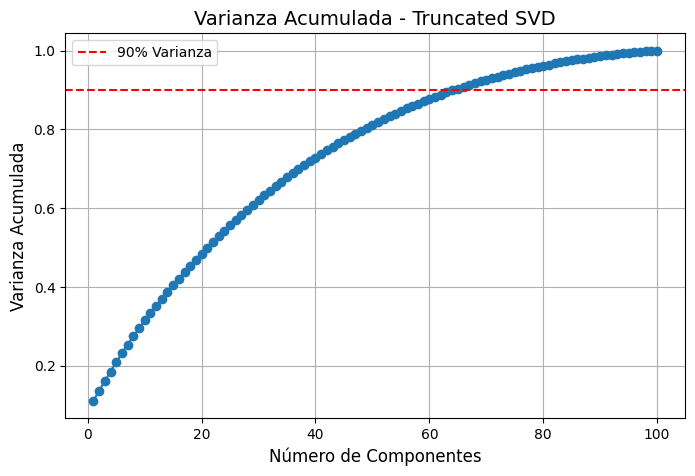

In [114]:
recommender = Recommender()
recommender.fit(df)
recommender.plot_elbow()

In [118]:
df[df['user_id']==10]

,user_id,item_id,interaction
268,10,72,1
795,10,0,1
1123,10,20,1
1220,10,85,1
1255,10,84,1
1417,10,77,1
1501,10,86,1
1503,10,39,1
1681,10,61,1
1730,10,28,1


In [135]:
recommender.generate_model(df, n_components=7, threshold=0.7)
recommendations = recommender.recommend(df, item_id=72)
recommendations

[0, 7, 17, 34, 39, 42, 57, 76, 86, 89, 97]

In [136]:
user_id_to_recommend = 10  # Replace with the desired user_id
recommendations_for_user = recommender.recommend_to_user(user_id_to_recommend, df)
print(f"Recommendations for user {user_id_to_recommend}: {recommendations_for_user}")


Recommendations for user 10: []


In [121]:
seen_items = set(df[df['user_id'] == 10]['item_id'])
seen_items

{0, 15, 20, 28, 39, 61, 72, 77, 82, 84, 85, 86}

In [138]:
recommendations = []
for item_id in seen_items:

    # Get the correlation for the current item with all other items
    corr_recom = corrMtx[item_id]

    # Get the correlation for the current item with the target item_id
    corr_with_target = corr_recom[utility_matrix.columns.get_loc(item_id)]

    # Check if the correlation with the target item is above the threshold and not already seen
    if (corr_with_target > 0.5) and (corr_with_target < 0.99) and (item_id not in seen_items):
        recommendations.append(item_id)

print(recommendations[:5])

[ 1.          0.31126735  0.78496338  0.66354846  0.37137085  0.30732567
  0.36694667  0.89363751  0.70816535  0.52109455  0.38993465  0.09183657
  0.52710011  0.18337156  0.63385478  0.85724321  0.39136944  0.80825982
  0.29123936  0.24994117  0.59724724  0.3586042   0.65002408  0.43011936
  0.50691818  0.64151528  0.45561567  0.29707852  0.69356913  0.53197767
  0.29951856  0.42371535  0.24558185  0.89493588  0.39409173  0.87814868
  0.65230926  0.45125531  0.47038129  0.9284177   0.4214917   0.73831404
  0.90474998  0.76230676 -0.0079379   0.51996467  0.14315799  0.52898284
  0.75410754  0.47995648  0.53461668  0.58464425  0.31933341  0.70414473
  0.50517159  0.63739922  0.81574079  0.56423696  0.80791647  0.42872114
  0.40417715  0.57631557  0.60259239  0.69813349  0.4292809   0.65310402
  0.11708808  0.27025282  0.68786624  0.62191018  0.39688766  0.53348344
  0.78231043  0.46847271  0.6513143   0.46187491  0.5998366   0.69973483
  0.23255351  0.6831792   0.82712226  0.70734014  0

In [139]:
corr_recom[utility_matrix.columns.get_loc(0)]

np.float64(0.5763155733683812)

In [142]:
list(utility_matrix.columns[(corr_recom > 0.5) & (corr_recom < 0.99)])

[0,
 1,
 3,
 4,
 5,
 8,
 9,
 12,
 15,
 16,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 31,
 32,
 33,
 34,
 36,
 39,
 40,
 41,
 42,
 43,
 45,
 46,
 47,
 48,
 50,
 51,
 53,
 54,
 55,
 56,
 58,
 60,
 62,
 63,
 66,
 67,
 68,
 69,
 70,
 75,
 77,
 79,
 80,
 82,
 84,
 85,
 87,
 88,
 92,
 95,
 96,
 97,
 99]